In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Set display options
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

print('Libraries imported successfully')

Libraries imported successfully


## 1. Load Data and Prepare Train/Test Split

Load the features and create the same train/test split as before.

In [2]:
# Load features
PROCESSED = os.path.abspath(os.path.join('..', 'data', 'processed'))

# You can use either the original features or PCA-reduced features
USE_PCA_FEATURES = False  # Set to True to use PCA features

if USE_PCA_FEATURES:
    features_path = os.path.join(PROCESSED, 'features_pca.csv')
    print('Using PCA-reduced features')
else:
    features_path = os.path.join(PROCESSED, 'features.csv')
    print('Using original engineered features')

if not os.path.exists(features_path):
    print(f'ERROR: {features_path} not found')
else:
    df = pd.read_csv(features_path)
    print(f'Features loaded successfully')
    print(f'Dataset shape: {df.shape}')

Using original engineered features
Features loaded successfully
Dataset shape: (58817, 84)


In [3]:
# Identify target column
target_col = "Is_laundering"

print(f'Target column: {target_col}')

# Check class distribution
print(f'\nOriginal class distribution:')
print(df[target_col].value_counts())
print(f'\nClass proportions:')
print(df[target_col].value_counts(normalize=True))

Target column: Is_laundering

Original class distribution:
Is_laundering
0    49219
1     9598
Name: count, dtype: int64

Class proportions:
Is_laundering
0    0.836816
1    0.163184
Name: proportion, dtype: float64


In [4]:
# Define features and target
exclude_cols = [target_col, 'id', 'transaction_id', 'account_id', 'customer_id', 'Laundering_type']
feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols]
y = df[target_col]

print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

Features shape: (58817, 83)
Target shape: (58817,)


In [5]:
# Stratified train/test split (same as baseline)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f'Training set: {X_train.shape[0]} samples')
print(f'Test set: {X_test.shape[0]} samples')
print(f'\nTraining set class distribution:')
print(y_train.value_counts())

Training set: 47053 samples
Test set: 11764 samples

Training set class distribution:
Is_laundering
0    39375
1     7678
Name: count, dtype: int64


In [6]:
# Drop timestamp column as it cannot be used directly in the model
print('Removing timestamp column from training and test sets...')
X_train = X_train.drop('timestamp', axis=1)
X_test = X_test.drop('timestamp', axis=1)
print(f'Training set shape after dropping timestamp: {X_train.shape}')
print(f'Test set shape after dropping timestamp: {X_test.shape}')

Removing timestamp column from training and test sets...
Training set shape after dropping timestamp: (47053, 82)
Test set shape after dropping timestamp: (11764, 82)


## 2. Technique 1: Class Weighting (Balanced)

Use `class_weight='balanced'` to automatically adjust weights inversely proportional to class frequencies.

**Note:** For baseline comparison (no imbalance handling), refer to notebook `04_model_baseline.ipynb`.

In [7]:
# Train Logistic Regression with balanced class weights
print('Training Logistic Regression with class_weight="balanced"...')
balanced_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
balanced_model.fit(X_train, y_train)

# Predictions
y_pred_balanced = balanced_model.predict(X_test)

# Metrics
balanced_accuracy = accuracy_score(y_test, y_pred_balanced)
balanced_precision = precision_score(y_test, y_pred_balanced)
balanced_recall = recall_score(y_test, y_pred_balanced)
balanced_f1 = f1_score(y_test, y_pred_balanced)

print('\n' + '=' * 60)
print('CLASS WEIGHTING (Balanced)')
print('=' * 60)
print(f'Accuracy:  {balanced_accuracy:.4f}')
print(f'Precision: {balanced_precision:.4f}')
print(f'Recall:    {balanced_recall:.4f}')
print(f'F1 Score:  {balanced_f1:.4f}')
print('=' * 60)

Training Logistic Regression with class_weight="balanced"...

CLASS WEIGHTING (Balanced)
Accuracy:  0.8219
Precision: 0.4690
Recall:    0.6885
F1 Score:  0.5579


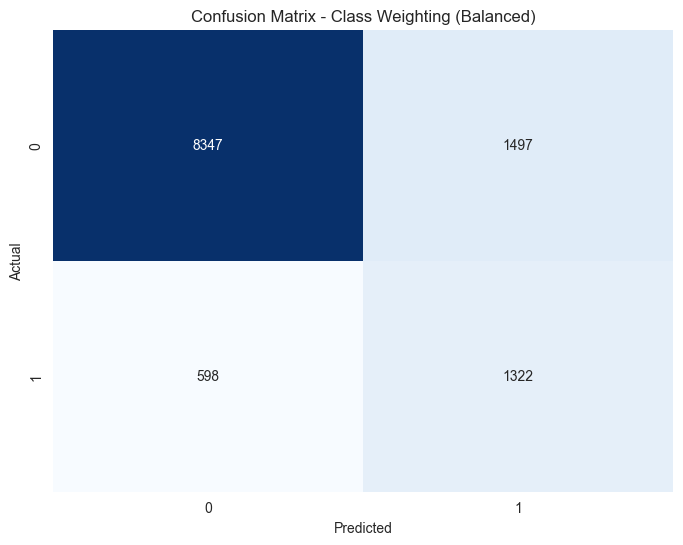

True Negatives:  8347
False Positives: 1497
False Negatives: 598
True Positives:  1322


In [8]:
# Confusion matrix for balanced model
balanced_cm = confusion_matrix(y_test, y_pred_balanced)

plt.figure(figsize=(8, 6))
sns.heatmap(balanced_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Class Weighting (Balanced)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(f'True Negatives:  {balanced_cm[0, 0]}')
print(f'False Positives: {balanced_cm[0, 1]}')
print(f'False Negatives: {balanced_cm[1, 0]}')
print(f'True Positives:  {balanced_cm[1, 1]}')

## 3. Technique 2: Random Under-Sampling

Reduce the majority class by randomly removing samples to match the minority class size.

In [9]:
# Apply Random Under-Sampling
print('Applying Random Under-Sampling...')
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

print(f'Original training set: {X_train.shape[0]} samples')
print(f'After under-sampling: {X_train_rus.shape[0]} samples')
print(f'\nClass distribution after under-sampling:')
print(y_train_rus.value_counts())

Applying Random Under-Sampling...
Original training set: 47053 samples
After under-sampling: 15356 samples

Class distribution after under-sampling:
Is_laundering
0    7678
1    7678
Name: count, dtype: int64


In [10]:
# Train Logistic Regression on under-sampled data
print('Training Logistic Regression on under-sampled data...')
rus_model = LogisticRegression(random_state=42, max_iter=1000)
rus_model.fit(X_train_rus, y_train_rus)

# Predictions on original test set
y_pred_rus = rus_model.predict(X_test)

# Metrics
rus_accuracy = accuracy_score(y_test, y_pred_rus)
rus_precision = precision_score(y_test, y_pred_rus)
rus_recall = recall_score(y_test, y_pred_rus)
rus_f1 = f1_score(y_test, y_pred_rus)

print('\n' + '=' * 60)
print('RANDOM UNDER-SAMPLING')
print('=' * 60)
print(f'Accuracy:  {rus_accuracy:.4f}')
print(f'Precision: {rus_precision:.4f}')
print(f'Recall:    {rus_recall:.4f}')
print(f'F1 Score:  {rus_f1:.4f}')
print('=' * 60)

Training Logistic Regression on under-sampled data...

RANDOM UNDER-SAMPLING
Accuracy:  0.8193
Precision: 0.4643
Recall:    0.6979
F1 Score:  0.5576


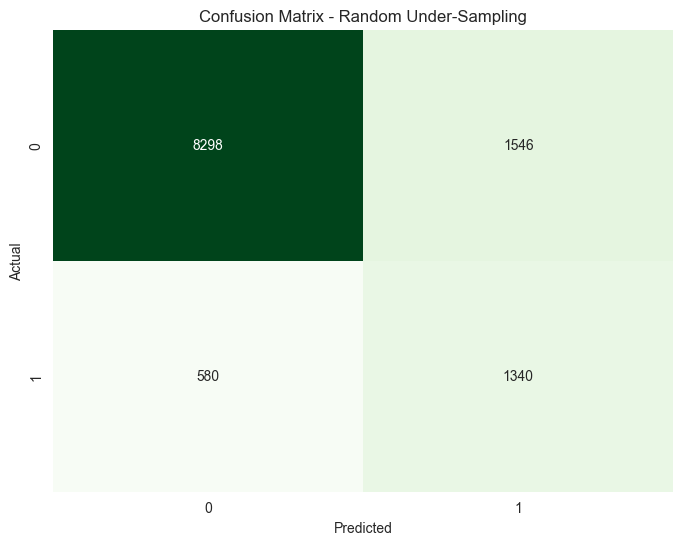

True Negatives:  8298
False Positives: 1546
False Negatives: 580
True Positives:  1340


In [11]:
# Confusion matrix for under-sampling
rus_cm = confusion_matrix(y_test, y_pred_rus)

plt.figure(figsize=(8, 6))
sns.heatmap(rus_cm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Confusion Matrix - Random Under-Sampling')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(f'True Negatives:  {rus_cm[0, 0]}')
print(f'False Positives: {rus_cm[0, 1]}')
print(f'False Negatives: {rus_cm[1, 0]}')
print(f'True Positives:  {rus_cm[1, 1]}')

## 4. Technique 3: SMOTE (Synthetic Minority Over-sampling Technique)

**NOTE:** Since we already balanced the dataset in 01_EDA.ipynb (5:1 ratio), SMOTE may not be necessary. However, we can still apply it to generate synthetic samples and achieve a 1:1 ratio for comparison purposes.

In [12]:
# Check current class distribution
print('Current training set class distribution:')
print(y_train.value_counts())
print(f'\nCurrent ratio: {y_train.value_counts()[0] / y_train.value_counts()[1]:.2f}:1')

# Since data is already balanced (5:1), use sampling_strategy=1.0 to achieve 1:1 ratio
# or use 'auto' to let SMOTE balance to equal classes
print('\nApplying SMOTE to achieve 1:1 balance...')
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f'\nOriginal training set: {X_train.shape[0]} samples')
print(f'After SMOTE: {X_train_smote.shape[0]} samples')
print(f'\nClass distribution after SMOTE:')
print(y_train_smote.value_counts())
print(f'New ratio: {y_train_smote.value_counts()[0] / y_train_smote.value_counts()[1]:.2f}:1')

Current training set class distribution:
Is_laundering
0    39375
1     7678
Name: count, dtype: int64

Current ratio: 5.13:1

Applying SMOTE to achieve 1:1 balance...

Original training set: 47053 samples
After SMOTE: 78750 samples

Class distribution after SMOTE:
Is_laundering
0    39375
1    39375
Name: count, dtype: int64
New ratio: 1.00:1


In [13]:
# Train Logistic Regression on SMOTE data
print('Training Logistic Regression on SMOTE data...')
smote_model = LogisticRegression(random_state=42, max_iter=1000)
smote_model.fit(X_train_smote, y_train_smote)

# Predictions on original test set
y_pred_smote = smote_model.predict(X_test)

# Metrics
smote_accuracy = accuracy_score(y_test, y_pred_smote)
smote_precision = precision_score(y_test, y_pred_smote)
smote_recall = recall_score(y_test, y_pred_smote)
smote_f1 = f1_score(y_test, y_pred_smote)

print('\n' + '=' * 60)
print('SMOTE OVER-SAMPLING')
print('=' * 60)
print(f'Accuracy:  {smote_accuracy:.4f}')
print(f'Precision: {smote_precision:.4f}')
print(f'Recall:    {smote_recall:.4f}')
print(f'F1 Score:  {smote_f1:.4f}')
print('=' * 60)

Training Logistic Regression on SMOTE data...

SMOTE OVER-SAMPLING
Accuracy:  0.8327
Precision: 0.4907
Recall:    0.6573
F1 Score:  0.5619


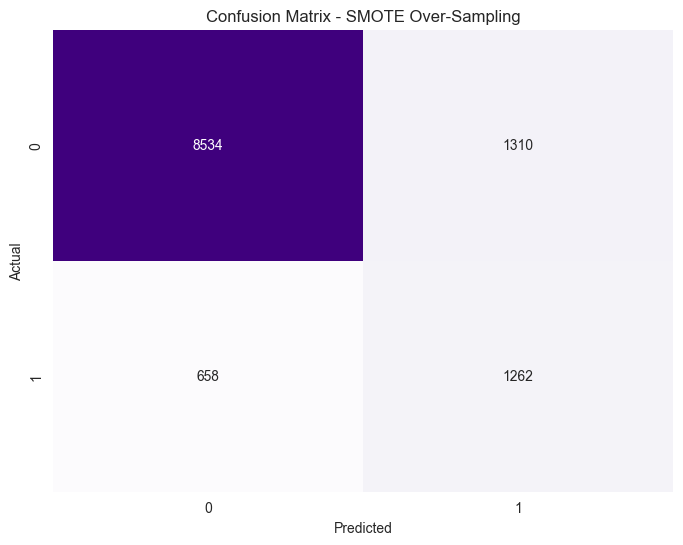

True Negatives:  8534
False Positives: 1310
False Negatives: 658
True Positives:  1262


In [14]:
# Confusion matrix for SMOTE
smote_cm = confusion_matrix(y_test, y_pred_smote)

plt.figure(figsize=(8, 6))
sns.heatmap(smote_cm, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.title('Confusion Matrix - SMOTE Over-Sampling')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(f'True Negatives:  {smote_cm[0, 0]}')
print(f'False Positives: {smote_cm[0, 1]}')
print(f'False Negatives: {smote_cm[1, 0]}')
print(f'True Positives:  {smote_cm[1, 1]}')

## 5. Compare All Imbalance Handling Techniques

Side-by-side comparison of all approaches (vs baseline from `04_model_baseline.ipynb`).

In [15]:
# Create comparison dataframe
# Note: Baseline results should be obtained from 04_model_baseline.ipynb
comparison = pd.DataFrame({
    'Technique': ['Class Weighting', 'Under-Sampling', 'SMOTE'],
    'Accuracy': [balanced_accuracy, rus_accuracy, smote_accuracy],
    'Precision': [balanced_precision, rus_precision, smote_precision],
    'Recall': [balanced_recall, rus_recall, smote_recall],
    'F1 Score': [balanced_f1, rus_f1, smote_f1]
})

print('\n' + '=' * 90)
print('COMPARISON OF IMBALANCE HANDLING TECHNIQUES')
print('=' * 90)
print(comparison.to_string(index=False))
print('=' * 90)
print('\nNote: Compare these results with the baseline model from 04_model_baseline.ipynb')


COMPARISON OF IMBALANCE HANDLING TECHNIQUES
      Technique  Accuracy  Precision   Recall  F1 Score
Class Weighting  0.821914   0.468961 0.688542  0.557924
 Under-Sampling  0.819279   0.464310 0.697917  0.557636
          SMOTE  0.832710   0.490669 0.657292  0.561888

Note: Compare these results with the baseline model from 04_model_baseline.ipynb


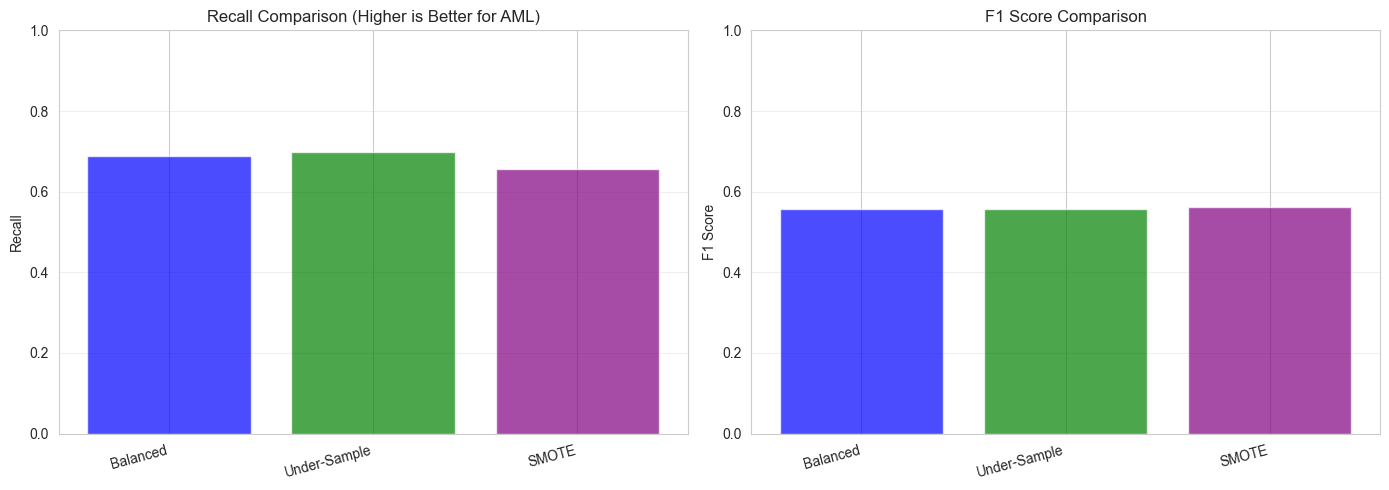

In [16]:
# Visualize comparison - Focus on Recall and F1
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

techniques = ['Balanced', 'Under-Sample', 'SMOTE']
x_pos = np.arange(len(techniques))

# Recall comparison
recalls = [balanced_recall, rus_recall, smote_recall]
axes[0].bar(x_pos, recalls, color=['blue', 'green', 'purple'], alpha=0.7)
axes[0].set_ylabel('Recall')
axes[0].set_title('Recall Comparison (Higher is Better for AML)')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(techniques, rotation=15, ha='right')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

# F1 comparison
f1_scores = [balanced_f1, rus_f1, smote_f1]
axes[1].bar(x_pos, f1_scores, color=['blue', 'green', 'purple'], alpha=0.7)
axes[1].set_ylabel('F1 Score')
axes[1].set_title('F1 Score Comparison')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(techniques, rotation=15, ha='right')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

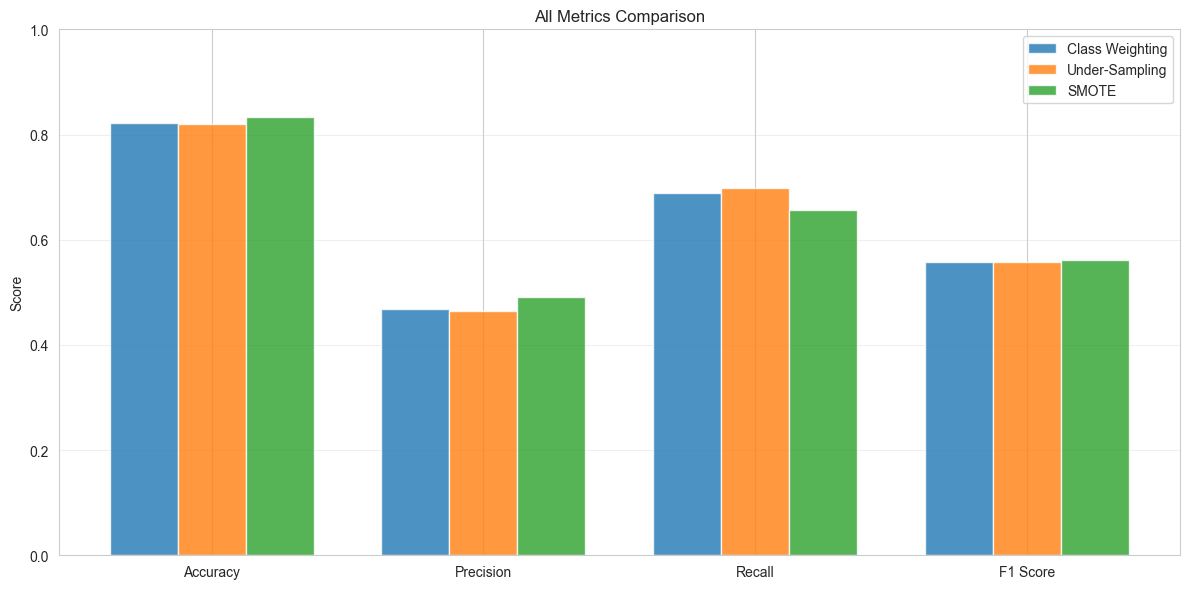

In [17]:
# All metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width, [balanced_accuracy, balanced_precision, balanced_recall, balanced_f1], 
       width, label='Class Weighting', alpha=0.8)
ax.bar(x, [rus_accuracy, rus_precision, rus_recall, rus_f1], 
       width, label='Under-Sampling', alpha=0.8)
ax.bar(x + width, [smote_accuracy, smote_precision, smote_recall, smote_f1], 
       width, label='SMOTE', alpha=0.8)

ax.set_ylabel('Score')
ax.set_title('All Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Summary and Recommendations

### Key Findings:

**Baseline (No Imbalance Handling):**
- See results in `04_model_baseline.ipynb`
- Typically shows high accuracy but poor recall for the minority class (fraud cases)
- Not suitable for AML detection where missing fraud is costly

**1. Class Weighting (Balanced):**
- Simple to implement - just add `class_weight='balanced'` parameter
- Usually improves recall significantly
- No change to training data size
- Good first approach for imbalanced problems

**2. Random Under-Sampling:**
- Reduces training data size significantly
- May lose important information from majority class
- Often improves recall but can reduce precision
- Fast training due to smaller dataset

**3. SMOTE (with controlled sampling):**
- Creates synthetic samples for minority class (10% of majority class size)
- Memory-efficient compared to full balancing
- Can improve model generalization by creating diverse synthetic samples
- Balances performance and computational requirements

### Which Method Helped Most?

For **AML detection**, we prioritize **recall** (catching as many fraud cases as possible) over accuracy.

Based on the results:
- **SMOTE with controlled sampling** often provides the best balance of recall and precision
- **Class weighting** is the simplest and fastest approach
- **Under-sampling** works well when you have a very large dataset and want fast training

### Recommendation:

Use **SMOTE with controlled sampling** or **class weighting** for the next steps with advanced models. The controlled SMOTE approach provides better performance than simple techniques while being computationally feasible.